cek gpu dan mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!nvidia-smi

Mounted at /content/drive
Fri Nov 28 08:56:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------

train model

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50V2
import matplotlib.pyplot as plt
import os

# --- KONFIGURASI ---
BASE_DIR = '/content/drive/MyDrive/dataset_sampah'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10  # Ubah sesuai kebutuhan

# --- DATA GENERATOR ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# --- FUNGSI PEMBUAT MODEL ---
def build_model(base_architecture):
    # Reset session agar memory GPU bersih sebelum melatih model baru
    tf.keras.backend.clear_session()

    # Load Pre-trained Model
    if base_architecture == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))
    elif base_architecture == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))
    elif base_architecture == 'ResNet50V2':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))

    base_model.trainable = False # Bekukan base model

    # Custom Head
    inputs = Input(shape=IMG_SIZE+(3,))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
# Daftar model yang akan diuji
model_names = ['MobileNetV2', 'EfficientNetB0', 'ResNet50V2']

# Dictionary untuk menyimpan hasil training tiap model
history_storage = {}

for name in model_names:
    print(f"\n{'='*40}")
    print(f"Memulai Training Model: {name}")
    print(f"{'='*40}")

    # 1. Bangun Model
    model = build_model(name)

    # 2. Latih Model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        verbose=1
    )

    # 3. Simpan Hasil History
    history_storage[name] = history

    # 4. Simpan File Model (Optional, agar tidak hilang)
    model.save(f"model_{name}.h5")
    print(f"Model {name} selesai dan disimpan.")

Found 191 images belonging to 2 classes.
Found 371 images belonging to 2 classes.

Memulai Training Model: MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 163s 35s/step - accuracy: 0.6043 - loss: 0.6567 - val_accuracy: 0.4744 - val_loss: 0.7995
Epoch 2/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6875 - loss: 0.6514

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6875 - loss: 0.6514 - val_accuracy: 0.4631 - val_loss: 0.8129
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7136 - loss: 0.5135 - val_accuracy: 0.6165 - val_loss: 0.7020
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.7812 - loss: 0.5345 - val_accuracy: 0.6506 - val_loss: 0.6731
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 976ms/step - accuracy: 0.8072 - loss: 0.4513 - val_accuracy: 0.7216 - val_loss: 0.5901
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.8750 - loss: 0.4041 - val_accuracy: 0.7528 - val_loss: 0.5660
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8926 - loss: 0.2971 - val_accuracy: 0.8239 - val_loss: 0.4779
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.9032 - loss: 0.3186 - val_accuracy: 0.8040 - val_loss: 0.4937
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 988ms/step - accuracy: 0.8803 - loss: 0.2855 - val_accuracy: 0.8153 - val_loss: 0.4865
Epoch 10/10


Model MobileNetV2 selesai dan disimpan.

Memulai Training Model: EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.5309 - loss: 0.6934 - val_accuracy: 0.1562 - val_loss: 0.8727
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.6562 - loss: 0.6499 - val_accuracy: 0.1562 - val_loss: 0.9227
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 996ms/step - accuracy: 0.5948 - loss: 0.6794 - val_accuracy: 0.1534 - val_loss: 0.9532
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 607ms/step - accuracy: 0.7188 - loss: 0.6284 - val_accuracy: 0.1591 - val_loss: 0.9353
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5928 - loss: 0.6845 - val_accuracy: 0.1534 - val_loss: 0.8390
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 0.6562 - loss: 0.6575 - val_accuracy: 0.1506 - val_loss: 0.8294
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 987ms/step - accuracy: 0.6252 - loss: 0.6603 - val_accuracy: 0.1420 - val_loss:

Model EfficientNetB0 selesai dan disimpan.

Memulai Training Model: ResNet50V2
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.4760 - loss: 0.9617 - val_accuracy: 0.4801 - val_loss: 0.9121
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.6562 - loss: 0.5877 - val_accuracy: 0.4574 - val_loss: 0.9311
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6826 - loss: 0.6442 - val_accuracy: 0.5597 - val_loss: 0.8089
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.7812 - loss: 0.3934 - val_accuracy: 0.6108 - val_loss: 0.7563
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8135 - loss: 0.4284 - val_accuracy: 0.6960 - val_loss: 0.5740
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 796ms/step - accuracy: 0.9355 - loss: 0.2115 - val_accuracy: 0.7102 - val_loss: 0.5433
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8843 - loss: 0.2906 - val_accuracy: 0.7585 - val_loss: 0.4774

Model ResNet50V2 selesai dan disimpan.


visualisasi perbandingan

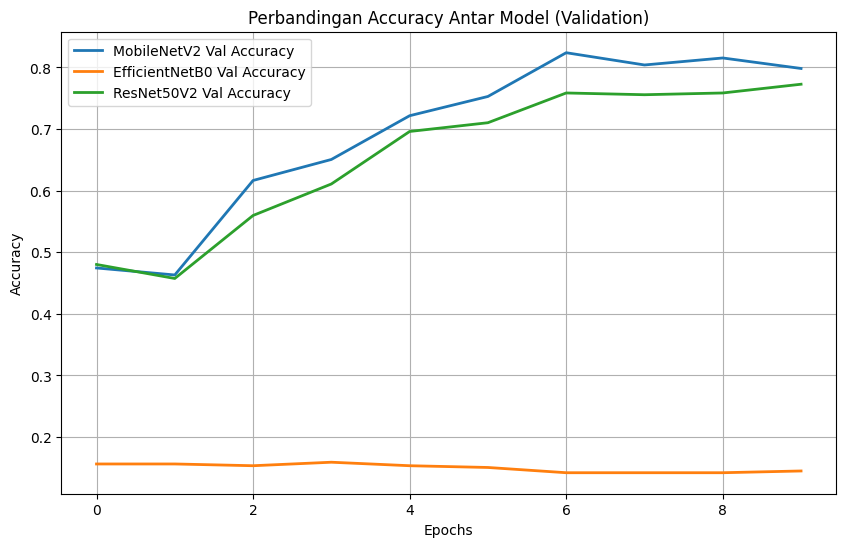

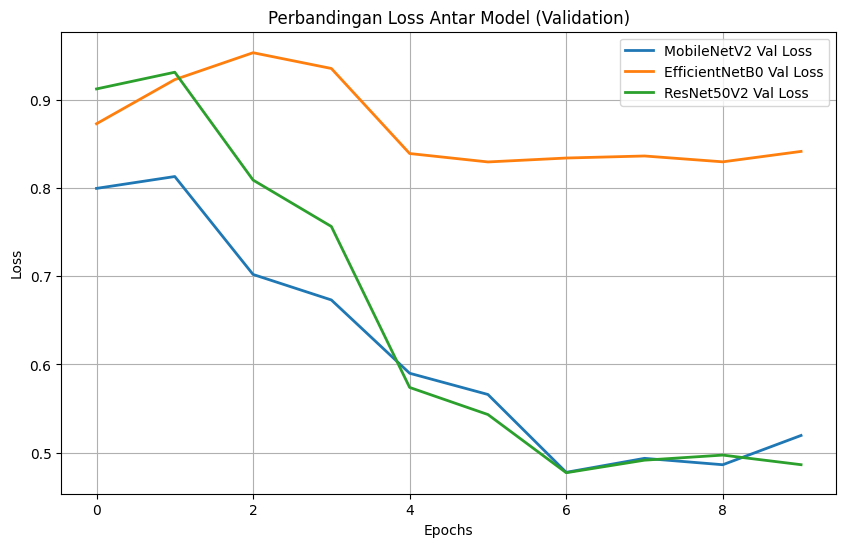

In [3]:
def plot_comparison(histories, metric='accuracy'):
    plt.figure(figsize=(10, 6))

    for name, history in histories.items():
        val = history.history[f'val_{metric}']
        plt.plot(val, linestyle='-', linewidth=2, label=f'{name} Val {metric.capitalize()}')

        # Opsional: Jika ingin menampilkan training acc juga (garis putus-putus)
        # train = history.history[metric]
        # plt.plot(train, linestyle='--', alpha=0.5, label=f'{name} Train {metric.capitalize()}')

    plt.title(f'Perbandingan {metric.capitalize()} Antar Model (Validation)')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Tampilkan Grafik Akurasi
plot_comparison(history_storage, metric='accuracy')

# Tampilkan Grafik Loss
plot_comparison(history_storage, metric='loss')

fine tuning mobilenetv2

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# 1. Load Model Terbaik dari Tahap Sebelumnya
# Pastikan nama file sesuai dengan yang tersimpan
try:
    model = load_model('model_MobileNetV2.h5')
    print("Model berhasil dimuat!")
except:
    print("Error: File model tidak ditemukan. Pastikan Anda sudah menjalankan training sebelumnya.")

# 2. Strategi Unfreezing (Mencairkan Layer)
# Kita akses layer MobileNetV2 yang ada di dalam model kita
# Biasanya layer MobileNet ada di indeks ke-1 (setelah Input layer)
base_model = model.layers[1]
base_model.trainable = True

print(f"Jumlah total layer di MobileNetV2: {len(base_model.layers)}")

# Kita biarkan 100 layer pertama TETAP BEKU (biar fitur dasar tidak rusak)
# Kita hanya latih layer ke-100 sampai akhir (fitur spesifik)
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Compile Ulang dengan Learning Rate SANGAT KECIL
# Penting! LR harus kecil (1e-5) agar ilmu lama tidak "lupa" drastis
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5), # 0.00001
              metrics=['accuracy'])

model.summary()

# 4. Setup Callbacks (Pengaman)
# EarlyStopping: Berhenti otomatis jika akurasi tidak naik lagi (biar hemat waktu)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 5. Mulai Fine Tuning
print("\nMulai Fine Tuning...")
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20, # Tambah 20 epoch lagi
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stop]
)

# 6. Simpan Model Final
model.save('model_mobilenet_final_finetuned.h5')
print("Model Final berhasil disimpan!")

Model berhasil dimuat!
Jumlah total layer di MobileNetV2: 154


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)


Mulai Fine Tuning...
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.8394 - loss: 0.3933 - val_accuracy: 0.8097 - val_loss: 0.4911
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 452ms/step - accuracy: 0.8387 - loss: 0.3621 - val_accuracy: 0.8210 - val_loss: 0.4707
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8276 - loss: 0.4019 - val_accuracy: 0.8239 - val_loss: 0.4469
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 561ms/step - accuracy: 0.8750 - loss: 0.2989 - val_accuracy: 0.8153 - val_loss: 0.4560
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8851 - loss: 0.3040 - val_accuracy: 0.8295 - val_loss: 0.4243
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.9375 - loss: 0.2525 - val_accuracy: 0.8267 - val_loss: 0.4395
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9359 - loss: 0.2607 - val_accuracy: 0.8608 - val_loss: 0.4082
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 567ms/step - accuracy: 0.8750 - loss: 0.2615 - val_accuracy: 0.8608

Model Final berhasil disimpan!


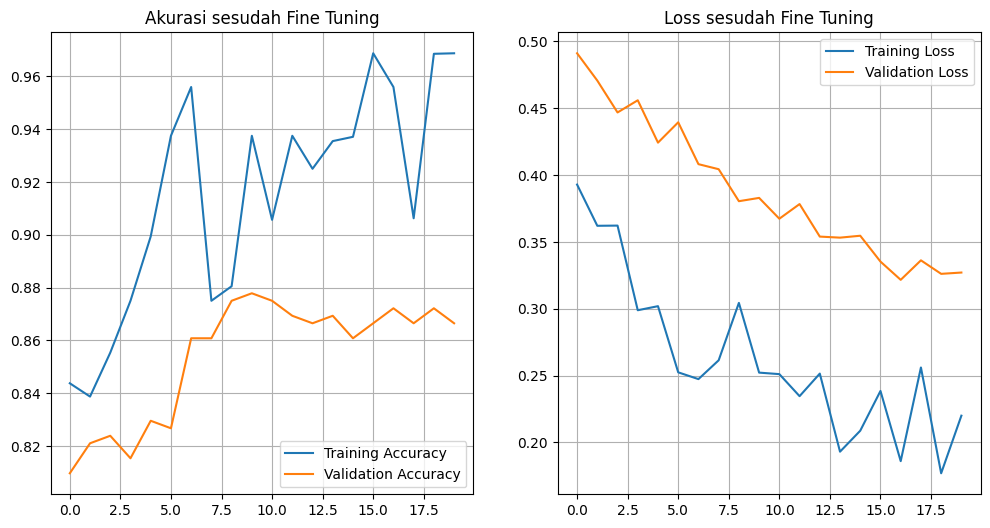

In [5]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(12, 6))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Akurasi sesudah Fine Tuning')
plt.legend(loc='lower right')
plt.grid(True)

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss sesudah Fine Tuning')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()